0.6535743068498442
0.7574667531864725
Time values: [ 0.    0.01  0.02 ...  9.98  9.99 10.  ]
Solution values:
[[0.00000000e+00 0.00000000e+00]
 [1.00000000e-02 5.22859445e-04]
 [2.00947681e-02 1.05403573e-03]
 ...
 [2.66022219e-01 2.33912700e+00]
 [2.55228418e-01 2.34128013e+00]
 [2.44312481e-01 2.34342592e+00]]


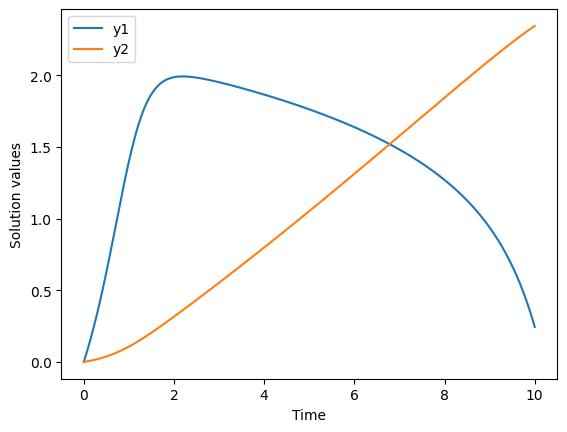

In [91]:
import numpy as np
import random
import matplotlib.pyplot as plt


a=random.uniform(0.6, 0.8)
print(a)
b=random.uniform(0.7,0.9)
print(b)
eps=0.08
I=1

def forward_euler_system(f, y0, t_span, h):
    t_values = np.arange(t_span[0], t_span[1] + h, h)
    y_values = [y0]

    for t in t_values[:-1]:
        y_next = y_values[-1] + h * np.array(f(t, y_values[-1]))
        y_values.append(y_next)

    return t_values, np.array(y_values)

# Example usage:
# Define the system of ODEs as a function f(t, y)
def f(t, y):
    dy1_dt = y[0] - (y[0]**3)/3 - y[1]+I
    dy2_dt = eps*(y[0] + a + b*y[1])
    return [dy1_dt, dy2_dt]

# Initial values
y0 = [0, 0]

# Time span and step size
t_span = [0, 10]
h = 0.01

# Solve the system using forward Euler
t_values, y_values = forward_euler_system(f, y0, t_span, h)

# Print or plot the results as needed
print("Time values:", t_values)
print("Solution values:")
print(y_values)

plt.plot(t_values, y_values[:, 0], label='y1')
plt.plot(t_values, y_values[:, 1], label='y2')
plt.xlabel('Time')
plt.ylabel('Solution values')
plt.legend()
plt.show()


In [92]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Initial values
y0 = [0, 0]
eps=0.08
I=1

# Time span and step size
t_span = [0, 10]
h = 0.01

def f(t, y, a, b):
    dy1_dt = y[0] - (y[0]**3)/3 - y[1]+I
    dy2_dt = eps*(y[0] + a + b*y[1])
    return [dy1_dt, dy2_dt]

def forward_euler_system(f, y0, t_span, h, a, b):
    t_values = np.arange(t_span[0], t_span[1] + h, h)
    y_values = [y0]

    for t in t_values[:-1]:
        y_next = y_values[-1] + h * np.array(f(t, y_values[-1], a, b))
        y_values.append(y_next)

    return t_values, np.array(y_values)

def Q(a,b):

    t_values, y_values = forward_euler_system(f, y0, t_span, h, a, b)
    S=0
    for i in range (len(y_values[0])-1):
        S+= (y_values[i,0]**2 +y_values[i+1,0]**2)/2
    return S*h

def IMC(M,seed):
    area=(0.2)**2
    np.random.seed(seed)
    A=np.random.uniform(0.6, 0.8,size=M)
    B=np.random.uniform(0.7,0.9,size=M)
    I=0
    for j in range (M):
        I+=Q(A[j],B[j])
    
    return I*area/M










2.0000000000000308e-08


In [93]:
import numpy.polynomial.legendre as L

def degree(n):
    if n!=0:
        list_=[0]*(n+1)
        list_[-1]=1
        return list_
    if n==0:
        return [1,0] #small fix, [1,0] is equivalent to [1] but they didn't like [1]

def V_mat(M, N, A ,B):
    V=np.ones((M,(N+1)**2))
    counter=0
    for i in range(0,N+1):
        for j in range(0,N+1):
            l_i=np.sqrt(2*i+1)*L.Legendre(degree(i), domain=[0.6, 0.8]) #normalization coefficient to ensure orthonormality of
            #Legendre polynomials 
            l_j=np.sqrt(2*j+1)*L.Legendre(degree(j), domain=[0.7, 0.9])
            V[:,counter]=[l_i(x)*l_j(y) for x,y in zip(A,B)]
            counter+=1
    return V, np.linalg.cond(V)

def coefficient(M, N, seed):
    np.random.seed(seed) #for reproducibility
    A=np.random.uniform(0.6, 0.8,size=M)
    B=np.random.uniform(0.7,0.9,size=M)
    V, cond_V=V_mat(M, N, A, B)
    Q_eval=np.array([Q(a,b) for a,b in zip(A,B)])
    c_coeff,_,_,_=np.linalg.lstsq(V,Q_eval, rcond=10**(-5))
    return c_coeff, cond_V

def IMCLS(M, N, seed_1, seed_2):
    area=(0.2)**2
    np.random.seed(seed_1)
    A=np.random.uniform(0.6, 0.8,size=M)
    B=np.random.uniform(0.7,0.9,size=M)
    c_coeff, cond_V=coefficient(M, N, seed_2)
    l_array=lambda x,y,n: np.array([np.sqrt(2*i+1)*L.Legendre(degree(i), domain=[0.6,0.8])(x)*
                                    np.sqrt(2*j+1)*L.Legendre(degree(j), domain=[0.7,0.8])(y) for i in range(0,n+1) for j in 
                                     range(0,n+1) ])
    Q_array=np.array([Q(x,y)-c_coeff@l_array(x,y, N) for x,y in zip(A,B)])
    
    IMCLS_value=np.mean(Q_array)+c_coeff[0]
    IMCLS_prime_val=c_coeff[0]
    return IMCLS_value*area



2.0000000000000007e-08
2.000000000000001e-08
2.000000000000016e-08
2.0000000000000047e-08
1.999999999999946e-08
